In [1]:
import pandas as pd

In [94]:
df= pd.read_csv('/Users/skirar/Downloads/healthcare-dataset-stroke-data.csv')

In [95]:
import warnings 
warnings.filterwarnings('ignore')

# basic libraries
import os
import numpy as np
import pandas as pd
import re
import string
from collections import Counter
import time

#visulaization modules
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

%matplotlib inline
init_notebook_mode(connected= True)




#Common model helpers
from sklearn.preprocessing import (StandardScaler,
                                   LabelEncoder,
                                   OneHotEncoder)
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, 
                             auc, 
                             precision_score,
                             recall_score,
                             f1_score, 
                             roc_auc_score,
                             confusion_matrix)
from sklearn.model_selection import (GridSearchCV,
                                     StratifiedKFold,
                                     cross_val_score)


# dimensionality reduction
from sklearn.decomposition import PCA
from umap import UMAP
import pylab as pl

# imbalance dataset handling

from imblearn.datasets import make_imbalance
from imblearn.under_sampling import (RandomUnderSampler, 
                                     ClusterCentroids,
                                     TomekLinks,
                                     NeighbourhoodCleaningRule,
                                     EditedNearestNeighbours,
                                     NearMiss)


from imblearn.over_sampling import (SMOTE,
                                    ADASYN)




# model algorithams
from sklearn.ensemble import (RandomForestClassifier, 
                              AdaBoostClassifier, 
                              GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [96]:
# checking first 5 rows of the data
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [98]:
#checking for missing values if any
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

#### Data from bmi feature is missing

In [99]:
# stats of numerical data
df.describe(exclude='object').apply(lambda x: round(x, 2))

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.00,5110.00,5110.0,5110.00,5110.00,4909.00,5110.00
mean,36517.83,43.23,0.1,0.05,106.15,28.89,0.05
std,21161.72,22.61,0.3,0.23,45.28,7.85,0.22
min,67.00,0.08,0.0,0.00,55.12,10.30,0.00
25%,17741.25,25.00,0.0,0.00,77.24,23.50,0.00
50%,36932.00,45.00,0.0,0.00,91.88,28.10,0.00
75%,54682.00,61.00,0.0,0.00,114.09,33.10,0.00
max,72940.00,82.00,1.0,1.00,271.74,97.60,1.00


In [100]:
#stats of categorical data
round(df.describe(include=['object']), 2)

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


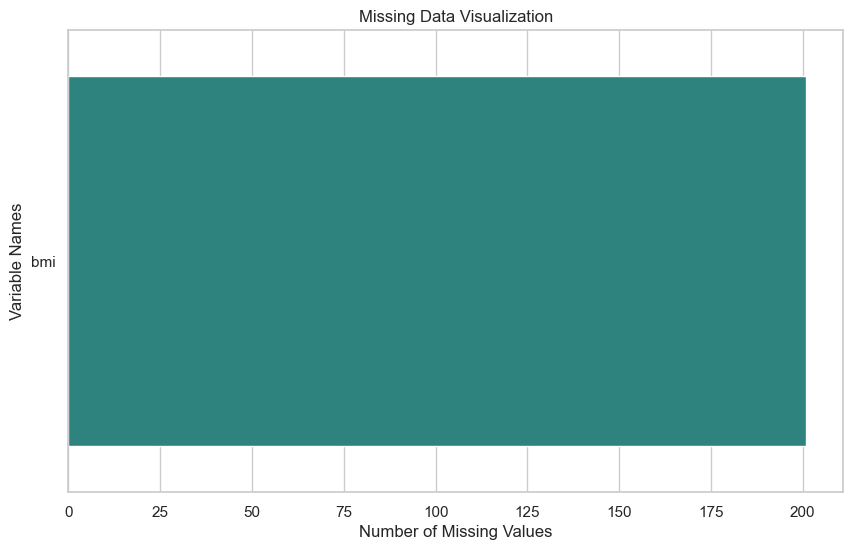

In [101]:
sns.set(style="whitegrid")  # Set the style for the plot
plt.figure(figsize=(10, 6))  # Set the figure size

# Create a bar chart to visualize missing data
missing_data = df.isnull().sum().sort_values(ascending=False)
missing_data = missing_data[missing_data > 0]
sns.barplot(x=missing_data.values, y=missing_data.index, palette="viridis")

# Customize the plot
plt.xlabel("Number of Missing Values")
plt.ylabel("Variable Names")
plt.title("Missing Data Visualization")

# Show the plot
plt.show()

this shows that there are 201 missing values in the column "bmi"

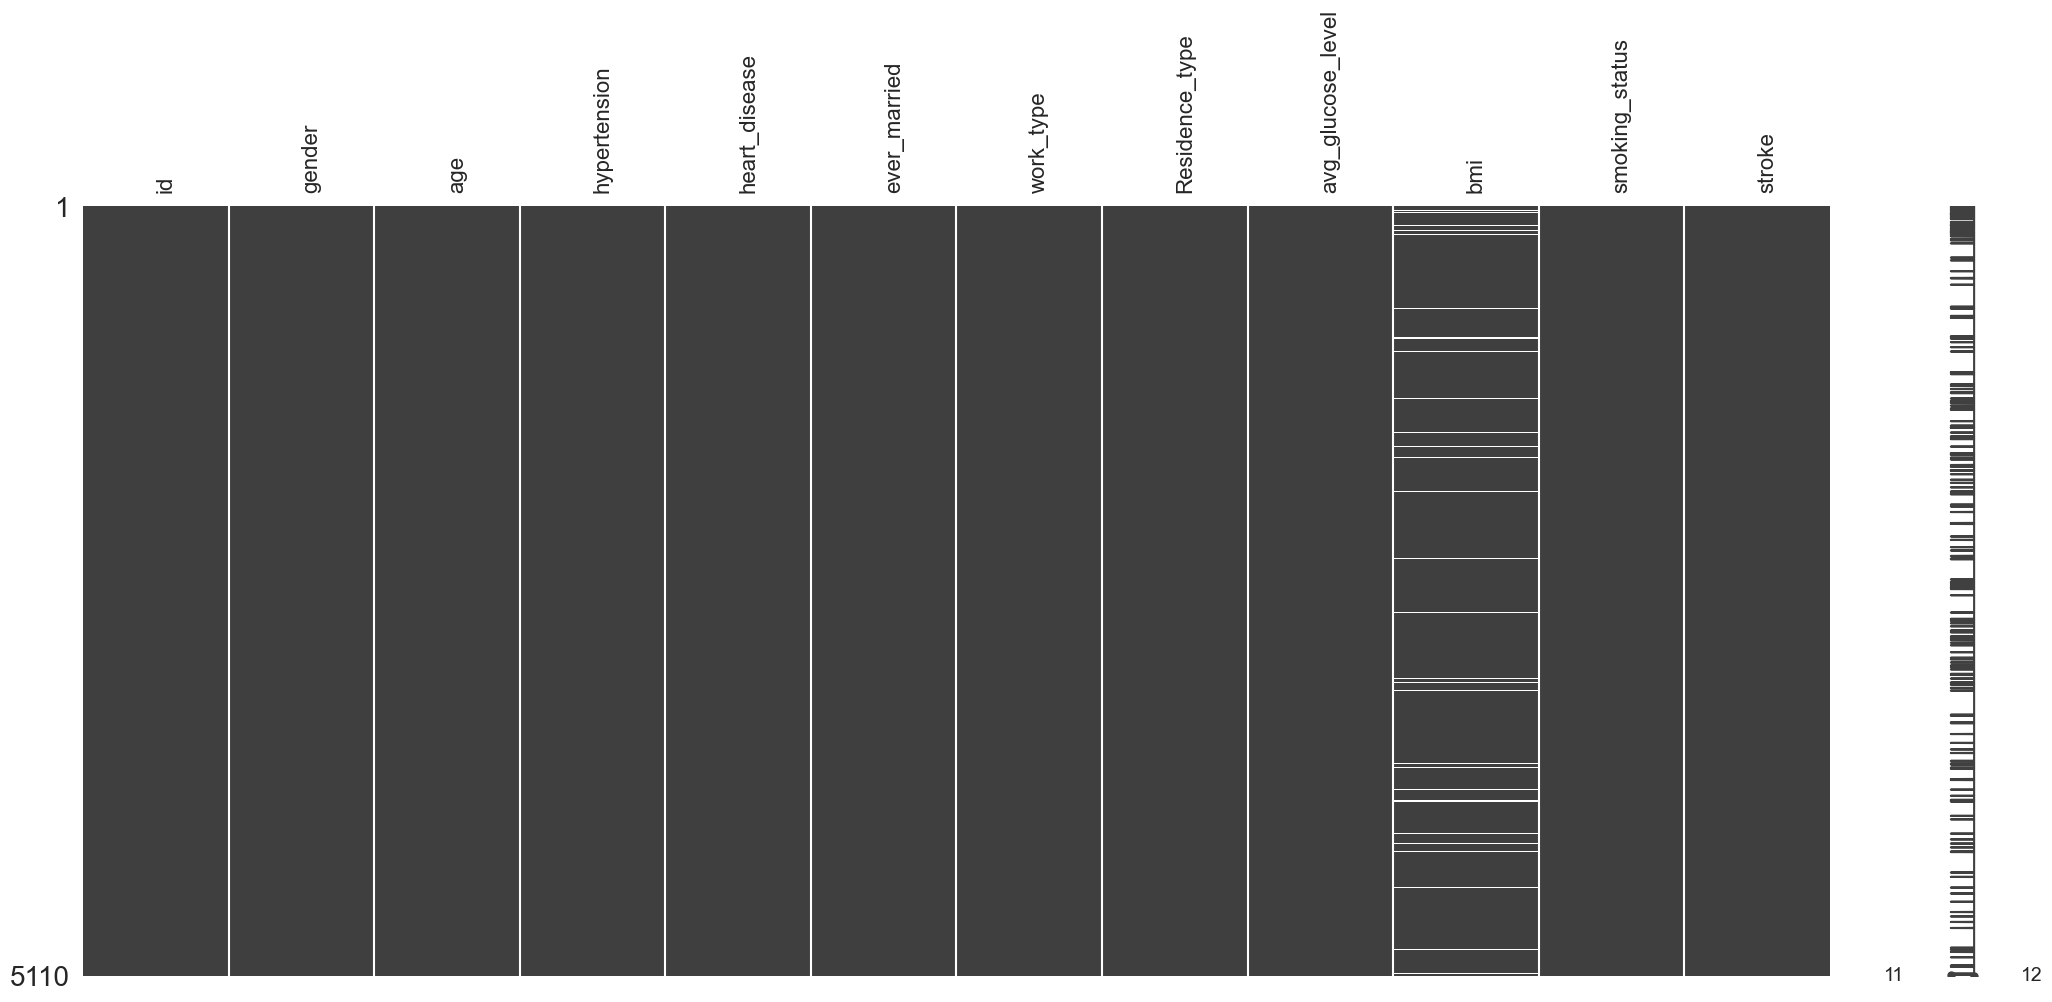

In [102]:
msno.matrix(df)

# Show all columns in the dataset
plt.xticks(range(df.shape[1]), df.columns, rotation=90)
plt.show()

In [103]:
#We fill the missing values in the Body Mass Index variable with the average value.

df['bmi'].fillna(df['bmi'].mean(), inplace=True)

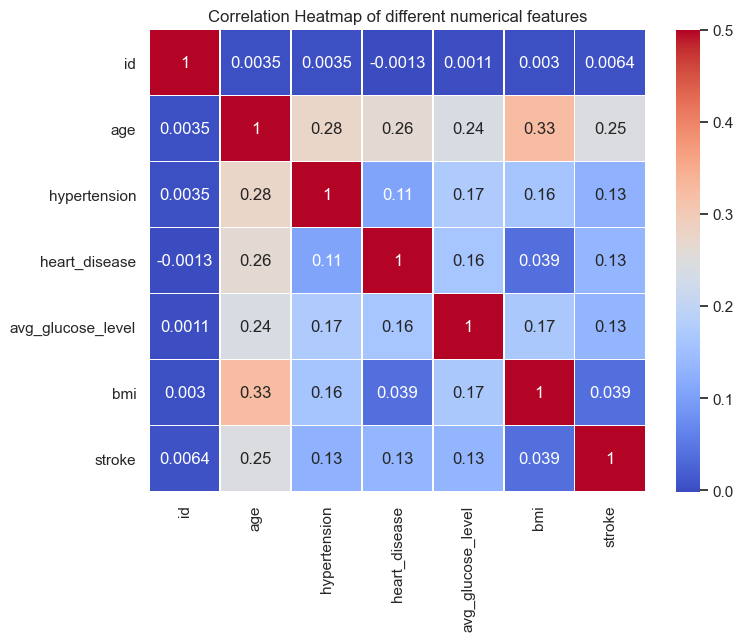

In [104]:
numeric_data = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numeric_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, vmax=0.50, cmap="coolwarm", linewidths=.5)
plt.title("Correlation Heatmap of different numerical features")
plt.show()

## 2.2 COUNT PLOT

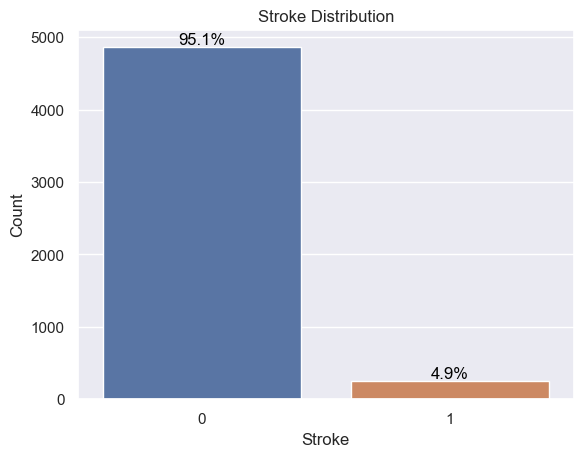

In [105]:
stroke_counts = df['stroke'].value_counts()

# Create a countplot
sns.set_theme(style='darkgrid')
ax = sns.countplot(data=df, x='stroke')

# Annotate the bars with percentages
total = len(df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

ax.set_xlabel('Stroke')
ax.set_ylabel('Count')

plt.title('Stroke Distribution')
plt.show()

It is a highly unbalanced distribution,\nand clearly seen that 5 in 100 people are susceptible to heart strokes. From distribution it is clear that almost every 5 people out of 100 people are having strokes from our sampling data. Moreover,this is a highly unbalanced data distribution, and null accuracy score of this distribution it self is 95%, whcih imploys any dump model should randomly predictions of stroke could reach accuracy of 95%. So, while modeling and training data, either over sampling or under sampling has to be done to obtain best results.

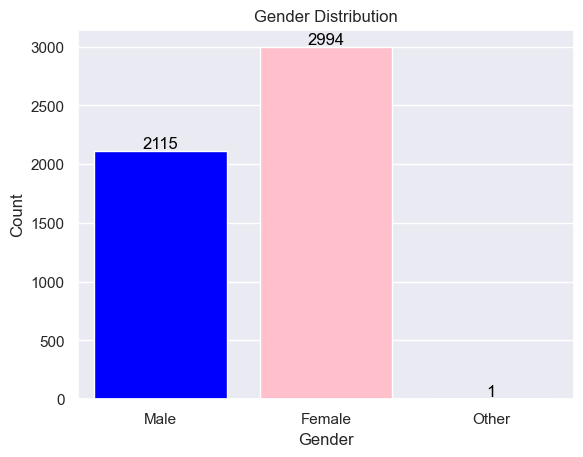

In [106]:
# Define the custom colors for each gender
colors = {"Male": "blue", "Female": "pink", "Other": "red"}

# Create a countplot with custom colors
sns.set_theme(style='darkgrid')
ax = sns.countplot(data=df, x='gender', palette=colors.values())
ax.set_xlabel('Gender')
ax.set_ylabel('Count')

# Annotate the bars with counts
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

# Set the colors for the bars
for i, patch in enumerate(ax.patches):
    patch.set_facecolor(list(colors.values())[i])

plt.title('Gender Distribution')
plt.show()

There are slightly more females in our sample data than males and from a visual perspective

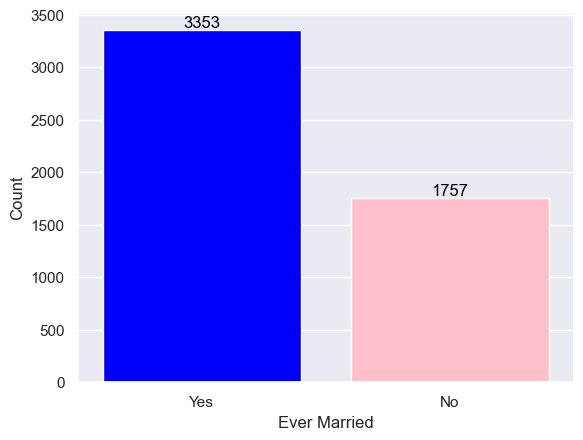

In [107]:
# Define the custom colors for each gender
colors = {"Yes": "blue", "No": "pink"}

# Create a countplot with custom colors
sns.set_theme(style='darkgrid')
ax = sns.countplot(data=df, x='ever_married', palette=colors.values())
ax.set_xlabel('Ever Married')
ax.set_ylabel('Count')

# Annotate the bars with counts
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

# Set the colors for the bars
for i, patch in enumerate(ax.patches):
    patch.set_facecolor(list(colors.values())[i])
plt.show()

work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64


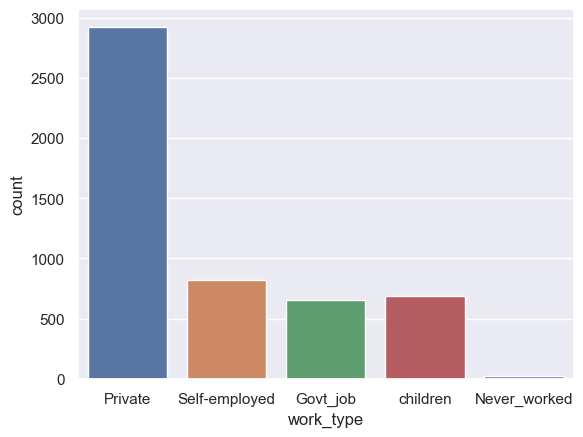

In [108]:
print(df.work_type.value_counts())
sns.set_theme(style='darkgrid')
ax = sns.countplot(data=df,x='work_type')

Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64


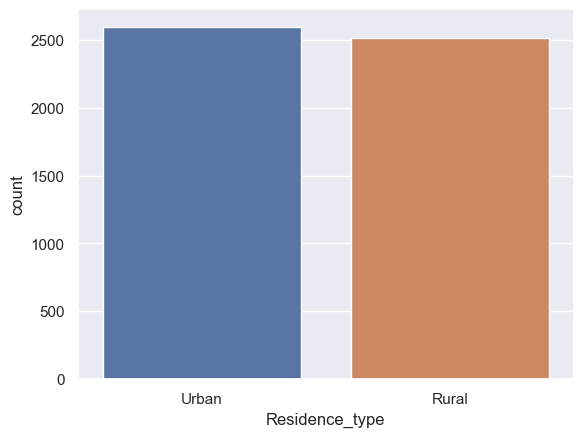

In [109]:
print(df.Residence_type.value_counts())
sns.set_theme(style='darkgrid')
ax = sns.countplot(data=df,x='Residence_type')

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64


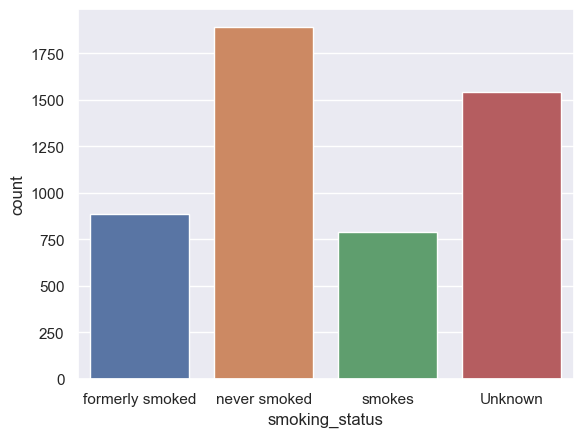

In [110]:
print(df.smoking_status.value_counts())
sns.set_theme(style='darkgrid')
ax = sns.countplot(data=df,x='smoking_status')

stroke
0    4861
1     249
Name: count, dtype: int64


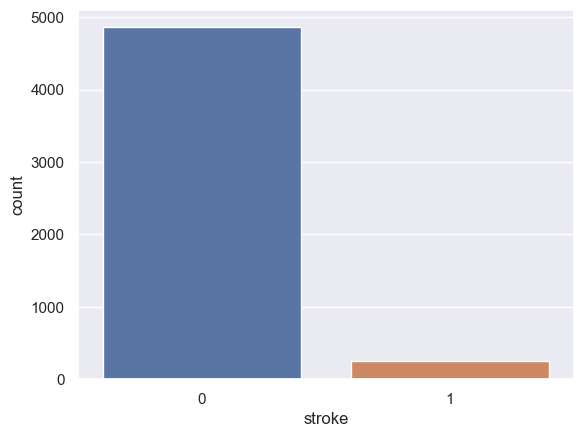

In [111]:
print(df.stroke.value_counts())
sns.set_theme(style='darkgrid')
ax = sns.countplot(data=df,x='stroke')

It is a highly unbalanced distribution,\nand clearly seen that 5 in 100 people are susceptible to heart strokes. From distribution it is clear that almost every 5 people out of 100 people are having strokes from our sampling data. Moreover,this is a highly unbalanced data distribution, and null accuracy score of this distribution it self is 95%, whcih imploys any dump model should randomly predictions of stroke could reach accuracy of 95%. So, while modeling and training data, either over sampling or under sampling has to be done to obtain best results.

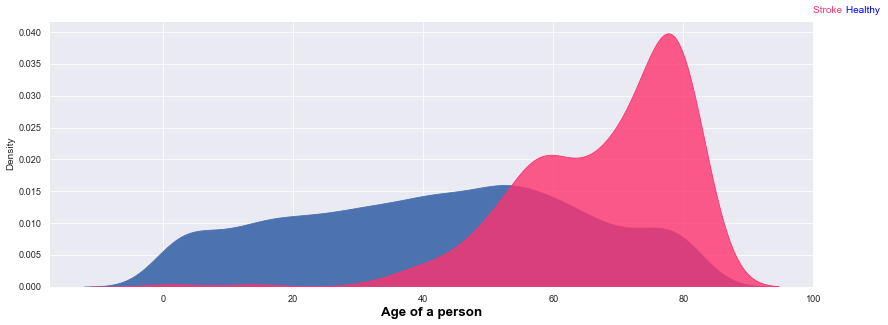

In [112]:
fig = plt.figure(figsize = (50,20), dpi = 60)
gs = fig.add_gridspec(10,24)
ax = fig.add_subplot(gs[6:9, 0:8]) #hue distribution plot
sns.kdeplot(data = df[df['stroke'] == 0], x = 'age',ax=ax , shade = True,  alpha = 1 )
sns.kdeplot(data = df[df['stroke'] == 1], x = 'age',ax=ax , shade = True,  alpha = 0.8, color= '#fe346e')
ax.set_xlabel('Age of a person',fontdict = {'color': 'black', 'weight':'bold','size': 16})
ax.text(100,0.043, 'Stroke ',{'color':'#fe346e'})
ax.text(105,0.043, 'Healthy ',{'color':'blue'})
fig.show()

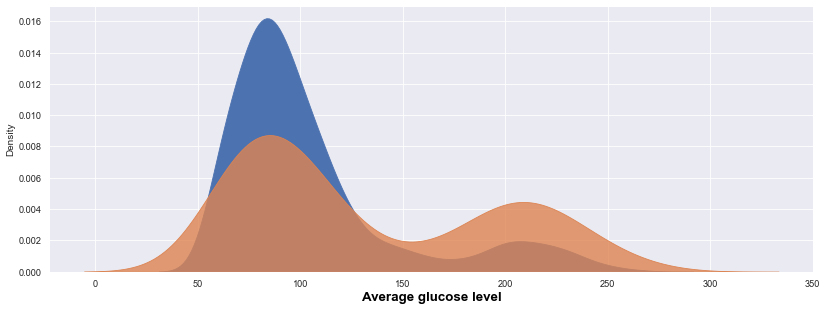

In [113]:
fig = plt.figure(figsize = (50,20), dpi = 60)
gs = fig.add_gridspec(10,24)
ax = fig.add_subplot(gs[6:9, 0:8]) #hue distribution plot
sns.kdeplot(data = df[df['stroke'] == 0], x = 'avg_glucose_level',ax=ax , shade = True,  alpha = 1 )
sns.kdeplot(data = df[df['stroke'] == 1], x = 'avg_glucose_level',ax=ax , shade = True,  alpha = 0.8)
ax.set_xlabel('Average glucose level',fontdict = {'color': 'black', 'weight':'bold','size': 16})
fig.show()

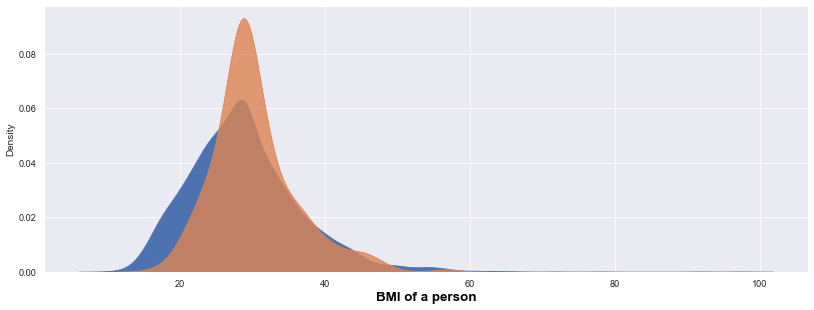

In [114]:
fig = plt.figure(figsize = (50,20), dpi = 60)
gs = fig.add_gridspec(10,24)
ax = fig.add_subplot(gs[6:9, 0:8]) #hue distribution plot
sns.kdeplot(data = df[df['stroke'] == 0], x = 'bmi',ax=ax , shade = True,  alpha = 1 )
sns.kdeplot(data = df[df['stroke'] == 1], x = 'bmi',ax=ax , shade = True,  alpha = 0.8)
ax.set_xlabel('BMI of a person',fontdict = {'color': 'black', 'weight':'bold','size': 16})
fig.show()

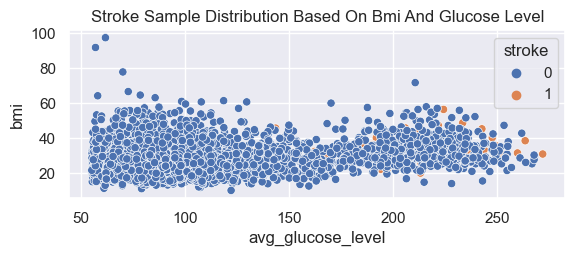

In [115]:
plt.subplot(2,1,1)
plt.title('Stroke Sample Distribution Based On Bmi And Glucose Level')
sns.scatterplot(x=df['avg_glucose_level'],y=df['bmi'],hue=df['stroke'])

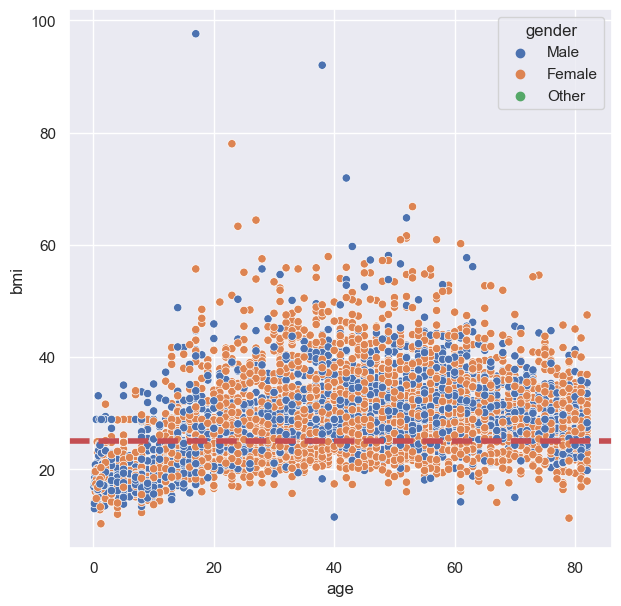

In [116]:
fig = plt.figure(figsize=(7,7))
graph = sns.scatterplot(data=df,x='age',y='bmi',hue='gender')
graph.axhline(y=25, linewidth=4,color='r',linestyle= '--')

In [117]:
stroke_population = df.query('stroke ==1').copy()
fig = ex.pie(stroke_population,names='smoking_status')
fig.update_layout(title='<b>Proportion Of Different Smoking Categories Among Stroke Population<b>')
fig.show()

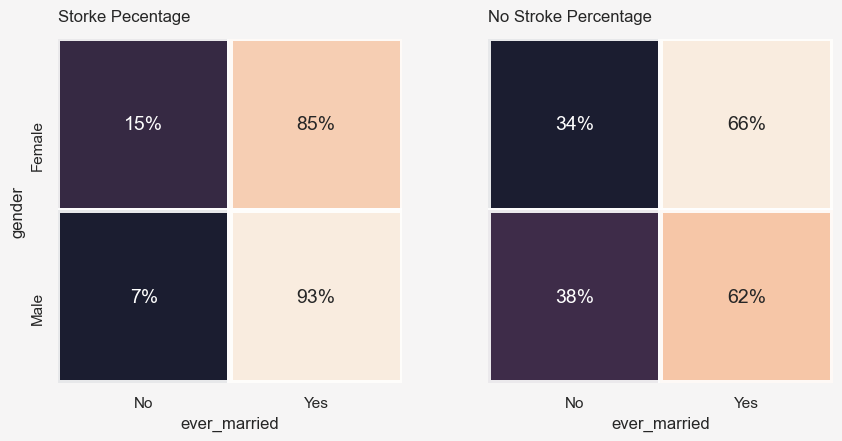

In [118]:
fig = plt.figure(figsize=(10,6),dpi = 100)
gs = fig.add_gridspec(1,2)
gs.update(wspace=0.25, hspace=0.5)

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

fig.patch.set_facecolor('#f6f5f5')
ax0.set_facecolor('#f6f5f5')
ax1.set_facecolor('#f6f5f5')
# ever_married, gender, residence, heart_disease and work_type
healthy = df[df['stroke']==0]
stroke = df[df['stroke']==1]
stroke = pd.crosstab(stroke['gender'],[stroke['ever_married']],normalize='index')
no_stroke = pd.crosstab(healthy['gender'],[healthy['ever_married']], normalize='index')

sns.heatmap(ax=ax0, data=stroke, linewidths= 0,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False,linewidth=3, annot=True, fmt='1.0%',annot_kws={"fontsize":14}, alpha = 0.9)

sns.heatmap(ax=ax1, data=no_stroke[0:-1], linewidths=0, 
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False,linewidth=3, annot=True, fmt='1.0%',annot_kws={"fontsize":14}, alpha = 0.9)

ax0.text(0,-0.1,'Storke Pecentage ')
ax1.text(0,-0.1,'No Stroke Percentage')

ax1.axes.get_yaxis().set_visible(False)
fig.show()

It is clear that married people are having more strokes as compared to singles. Married males are mostly effecting followed by married females

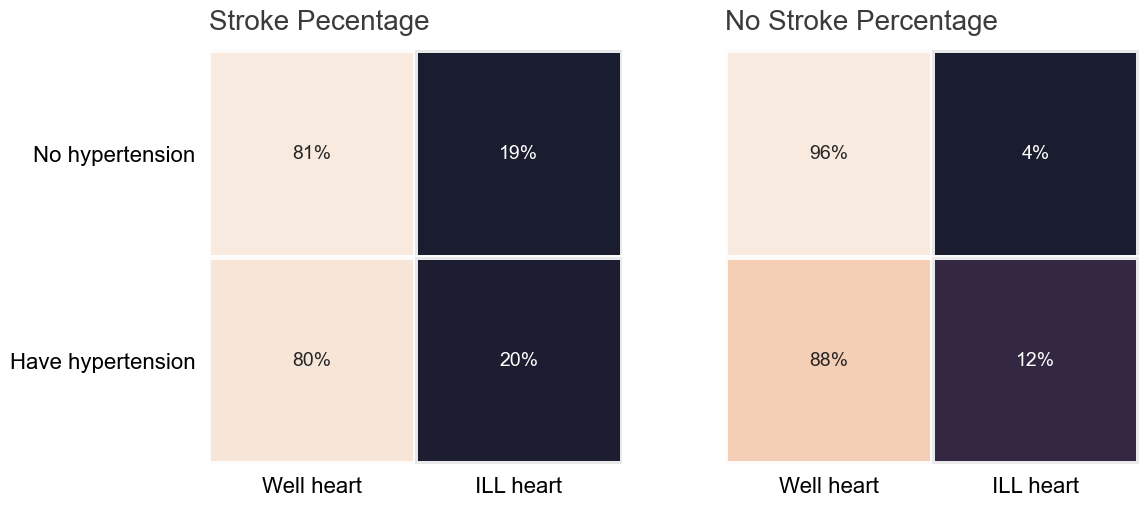

In [119]:
fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(1,2)
gs.update(wspace=0.25, hspace=0.5)

ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
healthy = df[df['stroke']==0]
stroke = df[df['stroke']==1]
stroke = pd.crosstab(stroke['hypertension'],[stroke['heart_disease']],normalize='index')
no_stroke = pd.crosstab(healthy['hypertension'],[healthy['heart_disease']], normalize='index')

sns.heatmap(ax=ax0, data=stroke, linewidths= 0,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False,linewidth=3,annot=True, fmt='1.0%',annot_kws={"fontsize":14}, alpha = 0.9)

sns.heatmap(ax=ax1, data=no_stroke, linewidths=0, 
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False,linewidth=3,annot=True, fmt='1.0%',annot_kws={"fontsize":14}, alpha = 0.9)
ax0.text(0,-0.1,'Stroke Pecentage ', { 'size':20},alpha = 0.9)
ax1.text(0,-0.1,'No Stroke Percentage', {'size':20}, alpha =0.9)

ax0.axes.set_xticklabels(['Well heart', 'ILL heart'], { 'color':'black', 'size':16})
ax1.axes.set_xticklabels(['Well heart', 'ILL heart'], {'color':'black', 'size':16})

ax0.axes.set_yticklabels(['No hypertension', 'Have hypertension'], {'color':'black', 'size':16}, rotation= 0)

ax0.set_xlabel('')
ax0.set_ylabel('')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.axes.get_yaxis().set_visible(False)
fig.show()

People with no heart condtion but hypertension are having most of the strokes.

# Modelling

In [120]:
#Data Preprocessing
dataset=df
x = dataset.iloc[:, 1:-1].values
y = dataset.iloc[:, -1].values
x

array([['Male', 67.0, 0, ..., 228.69, 36.6, 'formerly smoked'],
       ['Female', 61.0, 0, ..., 202.21, 28.893236911794666,
        'never smoked'],
       ['Male', 80.0, 0, ..., 105.92, 32.5, 'never smoked'],
       ...,
       ['Female', 35.0, 0, ..., 82.99, 30.6, 'never smoked'],
       ['Male', 51.0, 0, ..., 166.29, 25.6, 'formerly smoked'],
       ['Female', 44.0, 0, ..., 85.28, 26.2, 'Unknown']], dtype=object)

# Encoding

We are using **OneHotEncoder()** to encode the categorical columns: '**gender**', '**work_type**' and '**smoking_status**.

In [121]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers= [('encoder', OneHotEncoder(), [0,5,9])], remainder= 'passthrough')
x = np.array(ct.fit_transform(x))

## Label Encoding <a id="5.2"></a>

We are using **LabelEncoder()** to encode binary columns: '**ever_married**' and '**residence_type**'

In [122]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
x[:, 15] = le.fit_transform(x[:, 15])
x[:, 16] = le.fit_transform(x[:, 16])

In [123]:
print('Shape of X: ', x.shape)
print('Shape of Y: ', y.shape)

Shape of X:  (5110, 19)
Shape of Y:  (5110,)


# Splitting the dataset into the Training set and Test set <a id="6"></a>

In [124]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state= 0)

In [125]:
print("Number transactions x_train dataset: ", x_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions x_test dataset: ", x_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions x_train dataset:  (3577, 19)
Number transactions y_train dataset:  (3577,)
Number transactions x_test dataset:  (1533, 19)
Number transactions y_test dataset:  (1533,)


# Feature Scaling <a id="7"></a>

*StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance. Unit variance means dividing all the values by the standard deviation. StandardScaler results in a distribution with a standard deviation equal to 1.*

In [126]:
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

*SMOTE - **Synthetic Minority Oversampling Technique** is an oversampling technique where the synthetic samples are generated for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling.*

In [127]:
from imblearn.over_sampling import SMOTE

In [129]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(x_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 173
Before OverSampling, counts of label '0': 3404 

After OverSampling, the shape of train_X: (6808, 19)
After OverSampling, the shape of train_y: (6808,) 

After OverSampling, counts of label '1': 3404
After OverSampling, counts of label '0': 3404


# Model Selection <a id="9"></a>

In [130]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [131]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, RocCurveDisplay, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score

In [151]:
lst_1= []

In [147]:
# LR
lst_2= []
LRmodel= LogisticRegression(random_state=0)


LRmodel.fit(x_train_res, y_train_res)
y_pred = LRmodel.predict(x_test)
cm = confusion_matrix(y_test, y_pred)  #Confusion Matrix
accuracies = cross_val_score(estimator = LRmodel, X = x_train_res, y = y_train_res, cv = 10)   #K-Fold Validation
roc = roc_auc_score(y_test, y_pred)  #ROC AUC Score
precision = precision_score(y_test, y_pred)  #Precision Score
recall = recall_score(y_test, y_pred)  #Recall Score
f1 = f1_score(y_test, y_pred)  #F1 Score
print(LRmodel,':')
print(cm)
print('Accuracy Score: ',accuracy_score(y_test, y_pred))
print('')
print("K-Fold Validation Mean Accuracy: {:.2f} %".format(accuracies.mean()*100))
print('')
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))
print('')
print('ROC AUC Score: {:.2f}'.format(roc))
print('')
print('Precision: {:.2f}'.format(precision))
print('')
print('Recall: {:.2f}'.format(recall))
print('')
print('F1: {:.2f}'.format(f1))
print('-----------------------------------')
print('')
lst_2.append("LRmodel")
lst_2.append((accuracy_score(y_test, y_pred))*100) 
lst_2.append(accuracies.mean()*100)
lst_2.append(accuracies.std()*100)
lst_2.append(roc)
lst_2.append(precision)
lst_2.append(recall)
lst_2.append(f1)
lst_1.append(lst_2)

LogisticRegression(random_state=0) :
[[1120  337]
 [  22   54]]
Accuracy Score:  0.7658186562296151

K-Fold Validation Mean Accuracy: 80.04 %

Standard Deviation: 1.18 %

ROC AUC Score: 0.74

Precision: 0.14

Recall: 0.71

F1: 0.23
-----------------------------------



In [153]:
# SVM
lst_2= []
SVMmodel= SVC(random_state=0)


SVMmodel.fit(x_train_res, y_train_res)
y_pred = SVMmodel.predict(x_test)
cm = confusion_matrix(y_test, y_pred)  #Confusion Matrix
accuracies = cross_val_score(estimator = SVMmodel, X = x_train_res, y = y_train_res, cv = 10)   #K-Fold Validation
roc = roc_auc_score(y_test, y_pred)  #ROC AUC Score
precision = precision_score(y_test, y_pred)  #Precision Score
recall = recall_score(y_test, y_pred)  #Recall Score
f1 = f1_score(y_test, y_pred)  #F1 Score
print(SVMmodel,':')
print(cm)
print('Accuracy Score: ',accuracy_score(y_test, y_pred))
print('')
print("K-Fold Validation Mean Accuracy: {:.2f} %".format(accuracies.mean()*100))
print('')
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))
print('')
print('ROC AUC Score: {:.2f}'.format(roc))
print('')
print('Precision: {:.2f}'.format(precision))
print('')
print('Recall: {:.2f}'.format(recall))
print('')
print('F1: {:.2f}'.format(f1))
print('-----------------------------------')
print('')
lst_2.append("SVMmodel")
lst_2.append((accuracy_score(y_test, y_pred))*100) 
lst_2.append(accuracies.mean()*100)
lst_2.append(accuracies.std()*100)
lst_2.append(roc)
lst_2.append(precision)
lst_2.append(recall)
lst_2.append(f1)
lst_1.append(lst_2)

SVC(random_state=0) :
[[1217  240]
 [  50   26]]
Accuracy Score:  0.8108284409654273

K-Fold Validation Mean Accuracy: 89.23 %

Standard Deviation: 1.15 %

ROC AUC Score: 0.59

Precision: 0.10

Recall: 0.34

F1: 0.15
-----------------------------------



In [154]:
# KNeighbor
lst_2= []
KNmodel= KNeighborsClassifier()


KNmodel.fit(x_train_res, y_train_res)
y_pred = KNmodel.predict(x_test)
cm = confusion_matrix(y_test, y_pred)  #Confusion Matrix
accuracies = cross_val_score(estimator = KNmodel, X = x_train_res, y = y_train_res, cv = 10)   #K-Fold Validation
roc = roc_auc_score(y_test, y_pred)  #ROC AUC Score
precision = precision_score(y_test, y_pred)  #Precision Score
recall = recall_score(y_test, y_pred)  #Recall Score
f1 = f1_score(y_test, y_pred)  #F1 Score
print(KNmodel,':')
print(cm)
print('Accuracy Score: ',accuracy_score(y_test, y_pred))
print('')
print("K-Fold Validation Mean Accuracy: {:.2f} %".format(accuracies.mean()*100))
print('')
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))
print('')
print('ROC AUC Score: {:.2f}'.format(roc))
print('')
print('Precision: {:.2f}'.format(precision))
print('')
print('Recall: {:.2f}'.format(recall))
print('')
print('F1: {:.2f}'.format(f1))
print('-----------------------------------')
print('')
lst_2.append("KNmodel")
lst_2.append((accuracy_score(y_test, y_pred))*100) 
lst_2.append(accuracies.mean()*100)
lst_2.append(accuracies.std()*100)
lst_2.append(roc)
lst_2.append(precision)
lst_2.append(recall)
lst_2.append(f1)
lst_1.append(lst_2)

KNeighborsClassifier() :
[[1247  210]
 [  53   23]]
Accuracy Score:  0.8284409654272668

K-Fold Validation Mean Accuracy: 91.17 %

Standard Deviation: 0.94 %

ROC AUC Score: 0.58

Precision: 0.10

Recall: 0.30

F1: 0.15
-----------------------------------



In [155]:
# Decision Tree
lst_2= []
DTModel= DecisionTreeClassifier(random_state=0)

DTModel.fit(x_train_res, y_train_res)
y_pred = DTModel.predict(x_test)
cm = confusion_matrix(y_test, y_pred)  #Confusion Matrix
accuracies = cross_val_score(estimator = DTModel, X = x_train_res, y = y_train_res, cv = 10)   #K-Fold Validation
roc = roc_auc_score(y_test, y_pred)  #ROC AUC Score
precision = precision_score(y_test, y_pred)  #Precision Score
recall = recall_score(y_test, y_pred)  #Recall Score
f1 = f1_score(y_test, y_pred)  #F1 Score
print(DTModel,':')
print(cm)
print('Accuracy Score: ',accuracy_score(y_test, y_pred))
print('')
print("K-Fold Validation Mean Accuracy: {:.2f} %".format(accuracies.mean()*100))
print('')
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))
print('')
print('ROC AUC Score: {:.2f}'.format(roc))
print('')
print('Precision: {:.2f}'.format(precision))
print('')
print('Recall: {:.2f}'.format(recall))
print('')
print('F1: {:.2f}'.format(f1))
print('-----------------------------------')
print('')
lst_2.append("DTmodel")
lst_2.append((accuracy_score(y_test, y_pred))*100) 
lst_2.append(accuracies.mean()*100)
lst_2.append(accuracies.std()*100)
lst_2.append(roc)
lst_2.append(precision)
lst_2.append(recall)
lst_2.append(f1)
lst_1.append(lst_2)

DecisionTreeClassifier(random_state=0) :
[[1317  140]
 [  60   16]]
Accuracy Score:  0.8695368558382257

K-Fold Validation Mean Accuracy: 91.95 %

Standard Deviation: 2.00 %

ROC AUC Score: 0.56

Precision: 0.10

Recall: 0.21

F1: 0.14
-----------------------------------



In [156]:
# Random Forest
lst_2= []
RFmodel= RandomForestClassifier(random_state=0)

RFmodel.fit(x_train_res, y_train_res)
y_pred = SVMmodel.predict(x_test)
cm = confusion_matrix(y_test, y_pred)  #Confusion Matrix
accuracies = cross_val_score(estimator = RFmodel, X = x_train_res, y = y_train_res, cv = 10)   #K-Fold Validation
roc = roc_auc_score(y_test, y_pred)  #ROC AUC Score
precision = precision_score(y_test, y_pred)  #Precision Score
recall = recall_score(y_test, y_pred)  #Recall Score
f1 = f1_score(y_test, y_pred)  #F1 Score
print(RFmodel,':')
print(cm)
print('Accuracy Score: ',accuracy_score(y_test, y_pred))
print('')
print("K-Fold Validation Mean Accuracy: {:.2f} %".format(accuracies.mean()*100))
print('')
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))
print('')
print('ROC AUC Score: {:.2f}'.format(roc))
print('')
print('Precision: {:.2f}'.format(precision))
print('')
print('Recall: {:.2f}'.format(recall))
print('')
print('F1: {:.2f}'.format(f1))
print('-----------------------------------')
print('')
lst_2.append("RFmodel")
lst_2.append((accuracy_score(y_test, y_pred))*100) 
lst_2.append(accuracies.mean()*100)
lst_2.append(accuracies.std()*100)
lst_2.append(roc)
lst_2.append(precision)
lst_2.append(recall)
lst_2.append(f1)
lst_1.append(lst_2)

RandomForestClassifier(random_state=0) :
[[1217  240]
 [  50   26]]
Accuracy Score:  0.8108284409654273

K-Fold Validation Mean Accuracy: 96.21 %

Standard Deviation: 1.77 %

ROC AUC Score: 0.59

Precision: 0.10

Recall: 0.34

F1: 0.15
-----------------------------------



In [157]:
# XGBoost
lst_2= []
XGBmodel= XGBClassifier(eval_metric= 'error')


XGBmodel.fit(x_train_res, y_train_res)
y_pred = XGBmodel.predict(x_test)
cm = confusion_matrix(y_test, y_pred)  #Confusion Matrix
accuracies = cross_val_score(estimator = XGBmodel, X = x_train_res, y = y_train_res, cv = 10)   #K-Fold Validation
roc = roc_auc_score(y_test, y_pred)  #ROC AUC Score
precision = precision_score(y_test, y_pred)  #Precision Score
recall = recall_score(y_test, y_pred)  #Recall Score
f1 = f1_score(y_test, y_pred)  #F1 Score
print("XGBmodel",':')
print(cm)
print('Accuracy Score: ',accuracy_score(y_test, y_pred))
print('')
print("K-Fold Validation Mean Accuracy: {:.2f} %".format(accuracies.mean()*100))
print('')
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))
print('')
print('ROC AUC Score: {:.2f}'.format(roc))
print('')
print('Precision: {:.2f}'.format(precision))
print('')
print('Recall: {:.2f}'.format(recall))
print('')
print('F1: {:.2f}'.format(f1))
print('-----------------------------------')
print('')
lst_2.append("XGBmodel")
lst_2.append((accuracy_score(y_test, y_pred))*100) 
lst_2.append(accuracies.mean()*100)
lst_2.append(accuracies.std()*100)
lst_2.append(roc)
lst_2.append(precision)
lst_2.append(recall)
lst_2.append(f1)
lst_1.append(lst_2)

XGBmodel :
[[1396   61]
 [  69    7]]
Accuracy Score:  0.9151989562948467

K-Fold Validation Mean Accuracy: 95.18 %

Standard Deviation: 3.95 %

ROC AUC Score: 0.53

Precision: 0.10

Recall: 0.09

F1: 0.10
-----------------------------------



In [158]:
df = pd.DataFrame(lst_1, columns= ['Model', 'Accuracy', 'K-Fold Mean Accuracy', 'Std. Deviation', 'ROC AUC', 'Precision', 'Recall', 'F1'])

In [159]:
df.sort_values(by= ['Accuracy', 'K-Fold Mean Accuracy'], inplace= True, ascending= False)

In [160]:
df

,Model,Accuracy,K-Fold Mean Accuracy,Std. Deviation,ROC AUC,Precision,Recall,F1
5,XGBmodel,91.519896,95.182625,3.952280,0.525119,0.102941,0.092105,0.097222
3,DTmodel,86.953686,91.950894,1.999517,0.557219,0.102564,0.210526,0.137931
2,KNmodel,82.844097,91.172281,0.942397,0.579250,0.098712,0.302632,0.148867
4,RFmodel,81.082844,96.210439,1.767808,0.588692,0.097744,0.342105,0.152047
0,SVMmodel,81.082844,89.233523,1.146805,0.588692,0.097744,0.342105,0.152047
1,SVMmodel,81.082844,89.233523,1.146805,0.588692,0.097744,0.342105,0.152047


# Tuning the Models <a id="10"></a>

*The **GridSearchCV** is a library function that is a member of sklearn's model_selection package. It helps to loop through predefined hyperparameters and fit your estimator (model) on your training set. So, in the end, you can select the best parameters from the listed hyperparameters.*

In [163]:
grid_models = [(LogisticRegression(),[{'C':[0.25,0.5,0.75,1],'random_state':[0]}]), 
               (KNeighborsClassifier(),[{'n_neighbors':[5,7,8,10], 'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']}]), 
               (SVC(),[{'C':[0.25,0.5,0.75,1],'kernel':['linear', 'rbf'],'random_state':[0]}]), 
               (DecisionTreeClassifier(),[{'criterion':['gini','entropy'],'random_state':[0]}]), 
               (RandomForestClassifier(),[{'n_estimators':[100,150,200],'criterion':['gini','entropy'],'random_state':[0]}]), 
              (XGBClassifier(), [{'learning_rate': [0.01, 0.05, 0.1], 'eval_metric': ['error']}])]

In [164]:
for i,j in grid_models:
    grid = GridSearchCV(estimator=i,param_grid = j, scoring = 'accuracy',cv = 10)
    grid.fit(x_train_res, y_train_res)
    best_accuracy = grid.best_score_
    best_param = grid.best_params_
    print('{}:\nBest Accuracy : {:.2f}%'.format(i,best_accuracy*100))
    print('Best Parameters : ',best_param)
    print('')
    print('----------------')
    print('')

LogisticRegression():
Best Accuracy : 80.04%
Best Parameters :  {'C': 1, 'random_state': 0}

----------------

KNeighborsClassifier():
Best Accuracy : 92.64%
Best Parameters :  {'metric': 'manhattan', 'n_neighbors': 5}

----------------

SVC():
Best Accuracy : 89.23%
Best Parameters :  {'C': 1, 'kernel': 'rbf', 'random_state': 0}

----------------

DecisionTreeClassifier():
Best Accuracy : 91.99%
Best Parameters :  {'criterion': 'entropy', 'random_state': 0}

----------------

RandomForestClassifier():
Best Accuracy : 96.28%
Best Parameters :  {'criterion': 'gini', 'n_estimators': 150, 'random_state': 0}

----------------

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction

*Looking at output after **GridSearch**, we can determine that the **RandomForest** and **XGBoost** seems best fit for the model.*

## RandomForest <a id="11.1"></a>

*We only see **RandomForest** and **XGBoost** performance as they have high accuracy.*

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1457
           1       0.10      0.09      0.10        76

    accuracy                           0.91      1533
   macro avg       0.53      0.52      0.53      1533
weighted avg       0.91      0.91      0.91      1533

ROC AUC score: 0.7344444243759708
Accuracy Score:  0.9145466405740378


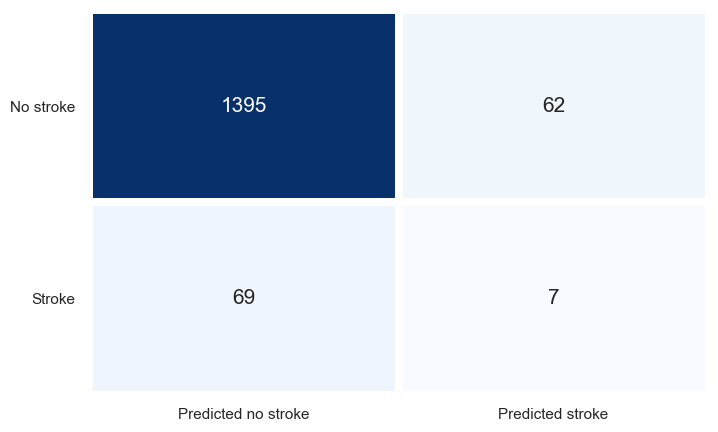

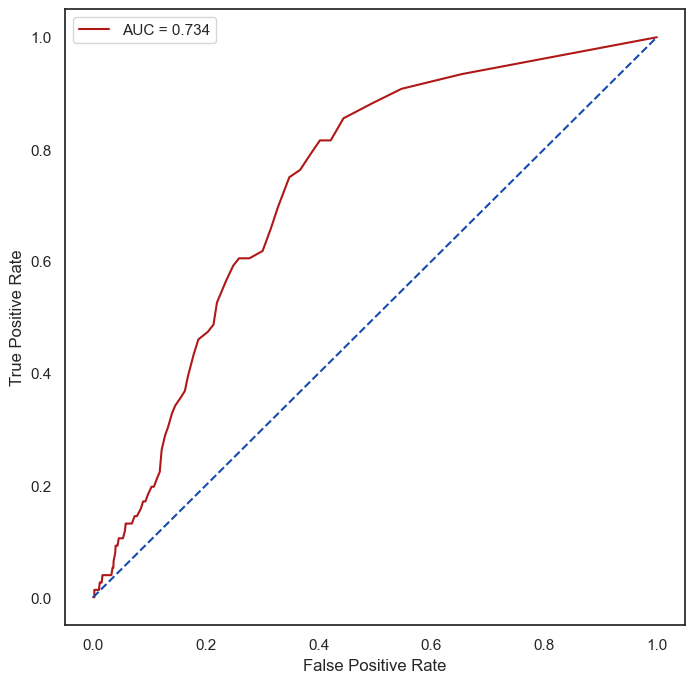

In [165]:
#Fitting RandomForest Model
classifier = RandomForestClassifier(criterion= 'gini', n_estimators= 100, random_state= 0)
classifier.fit(x_train_res, y_train_res)
y_pred = classifier.predict(x_test)
y_prob = classifier.predict_proba(x_test)[:,1]
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {roc_auc_score(y_test, y_prob)}')
print('Accuracy Score: ',accuracy_score(y_test, y_pred))

# Visualizing Confusion Matrix
plt.figure(figsize = (8, 5))
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc AUC Curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

## XGBoost <a id="11.2"></a>

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1457
           1       0.10      0.16      0.12        76

    accuracy                           0.89      1533
   macro avg       0.53      0.54      0.53      1533
weighted avg       0.91      0.89      0.90      1533

ROC AUC score: 0.7492685041361125
Accuracy Score:  0.8878016960208741


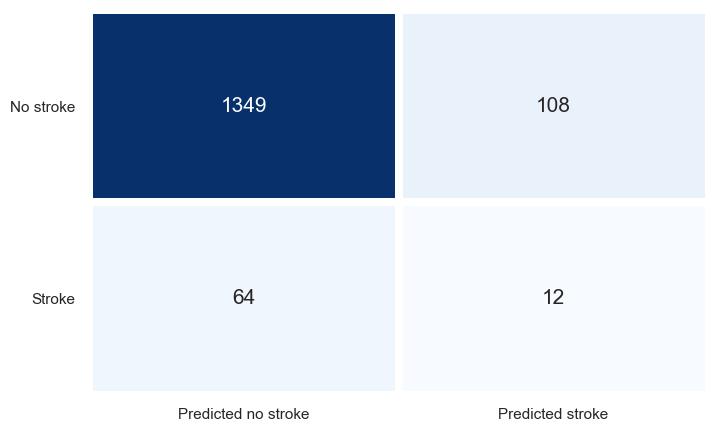

Text(0.5, 0, 'False Positive Rate')

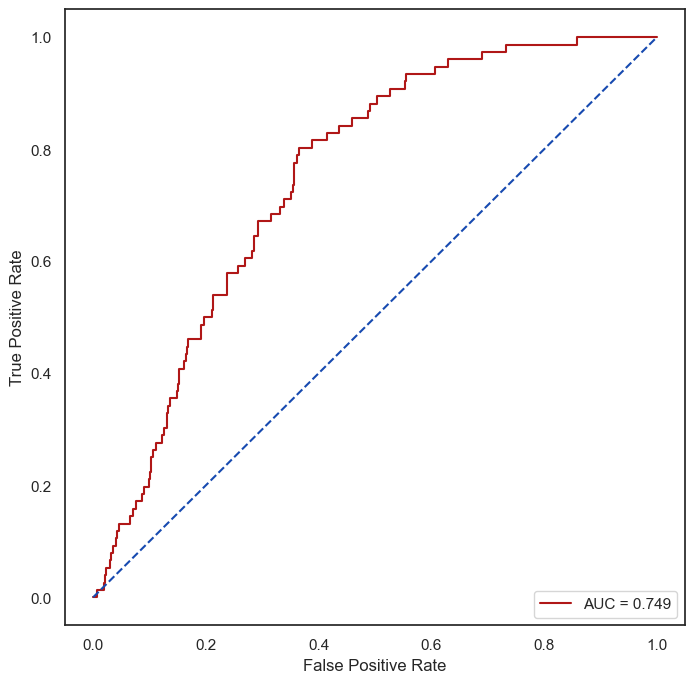

In [166]:
#Fitting XGBClassifier Model
classifier = XGBClassifier(eval_metric= 'error', learning_rate= 0.1)
classifier.fit(x_train_res, y_train_res)
y_pred = classifier.predict(x_test)
y_prob = classifier.predict_proba(x_test)[:,1]
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {roc_auc_score(y_test, y_prob)}')
print('Accuracy Score: ',accuracy_score(y_test, y_pred))

# Visualizing Confusion Matrix
plt.figure(figsize = (8, 5))
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc Curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Therefore, after the multiple visualizations of our and going through all the performance of the models. I tune the hyperparameters with the help of GridSearch to get models. After that, I came to conclusion that ***RandomForestClassifier*** is best model for this dataset.